$\newcommand{\vct}[1]{\boldsymbol{#1}}
\newcommand{\mtx}[1]{\mathbf{#1}}
\newcommand{\tr}{^\mathrm{T}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\lpa}{\left(}
\newcommand{\rpa}{\right)}
\newcommand{\lsb}{\left[}
\newcommand{\rsb}{\right]}
\newcommand{\lbr}{\left\lbrace}
\newcommand{\rbr}{\right\rbrace}
\newcommand{\fset}[1]{\lbr #1 \rbr}
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}$

# Single layer models

In this lab we will implement a single-layer network model consisting of solely of an affine transformation of the inputs. The relevant material for this was covered in [the slides of the first lecture](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/mlp01-intro.pdf). 

We will first implement the forward propagation of inputs to the network to produce predicted outputs. We will then move on to considering how to use gradients of a cost function evaluated on the outputs to compute the gradients with respect to the model parameters to allow us to perform an iterative gradient-descent training procedure.

## A general note on random number generators

It is generally a good practice (for machine learning applications **not** for cryptography!) to seed a pseudo-random number generator once at the beginning of each experiment. This makes it easier to reproduce results as the same random draws will produced each time the experiment is run (e.g. the same random initialisations used for parameters). 

Therefore generally when we need to generate random values during this course, we will create a seeded random number generator object as follows:

In [1]:
import numpy as np

# Seed a random number generator to be used later
seed = 27092016 
rng = np.random.RandomState(seed)

## Exercise 1: linear and affine transforms

Any *linear transform* (also called a linear map) of a finite-dimensional vector space can be parametrised by a matrix. So for example if we consider $\vct{x} \in \reals^{M}$ as the input space of a model with $M$ dimensional real-valued inputs, then a matrix $\mtx{W} \in \reals^{N\times M}$ can be used to define a prediction model consisting solely of a linear transform of the inputs

\begin{equation}
    \vct{y} = \mtx{W} \vct{x}
    \qquad
    \Leftrightarrow
    \qquad
    y_i = \sum_{j=1}^M \lpa W_{ij} x_j \rpa \qquad \forall i \in \fset{1 \dots N}
\end{equation}

with here $\vct{y} \in \reals^N$ the $N$-dimensional real-valued output of the model. Geometrically we can think of a linear transform doing some combination of rotation, scaling, reflection and shearing of the input.

An *affine transform* consists of a linear transform plus an additional translation parameterised by a vector $\vct{b} \in \reals^N$. A model consisting of an affine transformation of the inputs can then be defined as

\begin{equation}
    \vct{y} = \mtx{W}\vct{x} + \vct{b}
    \qquad
    \Leftrightarrow
    \qquad
    y_i = \sum_{j=1}^M \lpa W_{ij} x_j \rpa + b_i \qquad \forall i \in \fset{1 \dots N}
\end{equation}

In machine learning we will usually refer to the matrix $\mtx{W}$ as a *weight matrix* and the vector $\vct{b}$ as a *bias vector*. 

Implement *forward propagation* for a single-layer model consisting of an affine transformation of the inputs. This should work for a batch of inputs of shape `(batch_size, input_dim)` producing a batch of outputs of shape `(batch_size, output_dim)`. 

You may find the NumPy [`dot`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) function and [broadcasting features](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) useful.

In [2]:
def fprop(inputs, weights, biases):
    """Forward propagates activations through the layer transformation.

    For inputs `x`, outputs `y`, weights `W` and biases `b` the layer
    corresponds to `y = W x + b`.

    Args:
        inputs: Array of layer inputs of shape (batch_size, input_dim).
        weights: Array of weight parameters of shape 
            (output_dim, input_dim).
        biases: Array of bias parameters of shape (output_dim, ).

    Returns:
        outputs: Array of layer outputs of shape (batch_size, output_dim).
    """
    return weights.dot(inputs.T).T + biases

Check your implementation by running the test cell below

In [3]:
inputs = np.array([[0., -1., 2.], [-6., 3., 1.]])
weights = np.array([[2., -3., -1.], [-5., 7., 2.]])
biases = np.array([5., -3.])
true_outputs = np.array([[6., -6.], [-17., 50.]])

if not np.allclose(fprop(inputs, weights, biases), true_outputs):
    print('Wrong outputs computed.')
else:
    print('All outputs correct!')

All outputs correct!


## Exercise 2: visualising random models

In this exercise you will use your `fprop` implementation to visualise the outputs of a single-layer affine transform model with two-dimensional inputs and a one-dimensional output. In this simple case we can visualise the joint input-output space on a 3D axis.

For this task and the learning experiments later in the notebook we will use a regression dataset from the [UCI machine learning repository](http://archive.ics.uci.edu/ml/index.html). In particular we will use a version of the [Combined Cycle Power Plant dataset](http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant), where the task is to predict the energy output of a power plant given observations of the local ambient conditions (e.g. temperature, pressure and humidity).

The original dataset has four input dimensions and a single target output dimension. We have preprocessed the dataset by [whitening](https://en.wikipedia.org/wiki/Whitening_transformation) it, a common preprocessing step. We will only use the first two dimensions of the whitened inputs (corresponding to the first two principal components of the inputs) so we can easily visualise the joint input-output space.

The dataset has been wrapped in the `CCPPDataProvider` class in the `mlp.data_providers` module. Running the cell below will initialise an instance of this class, get a single batch of inputs and outputs and import the necessary `matplotlib` objects.

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mlp.data_providers import CCPPDataProvider
%matplotlib notebook

data_provider = CCPPDataProvider(
    which_set='train',
    input_dims=[0, 1],
    batch_size=5000, 
    max_num_batches=1, 
    shuffle_order=False
)

input_dim, output_dim = 2, 1

inputs, targets = data_provider.next()

Now run the cell below to plot the predicted outputs of a randomly initialised model across the two dimensional input space as well as the true target outputs. This sort of visualisation can be a useful method (in low dimensions) to assess how well the model is likely to be able to fit the data and to judge appropriate initialisation scales for the parameters. Each time you re-run the cell a new set of random parameters will be sampled

Some questions to consider:

  * How do the weights and bias initialisation scale affect the sort of predicted input-output relationships?
  * Does the linear form of the model seem a good fit for the data here?

<IPython.core.display.Javascript object>


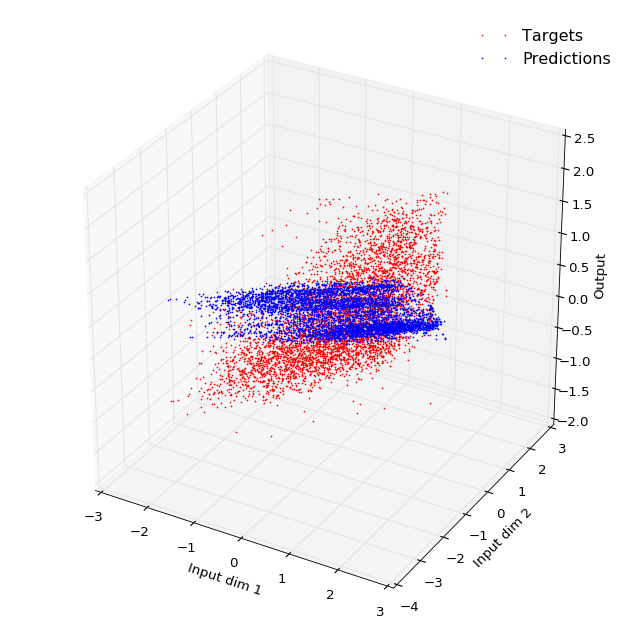

In [5]:
weights_init_range = 0.5
biases_init_range = 0.1

# Randomly initialise weights matrix
weights = rng.uniform(
    low=-weights_init_range, 
    high=weights_init_range, 
    size=(output_dim, input_dim)
)

#  Randomly initialise biases vector
biases = rng.uniform(
    low=-biases_init_range, 
    high=biases_init_range, 
    size=output_dim
)
# Calculate predicted model outputs
outputs = fprop(inputs, weights, biases)

# Plot target and predicted outputs against inputs on same axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(inputs[:, 0], inputs[:, 1], targets[:, 0], 'r.', ms=2)
ax.plot(inputs[:, 0], inputs[:, 1], outputs[:, 0], 'b.', ms=2)
ax.set_xlabel('Input dim 1')
ax.set_ylabel('Input dim 2')
ax.set_zlabel('Output')
ax.legend(['Targets', 'Predictions'], frameon=False)
fig.tight_layout()

## Exercise 3: computing the SSE cost function and its gradient

\begin{equation}
    C = \frac{1}{2} \sum_{i=1}^N \lbr (y_i - t_i)^2 \rbr
\end{equation}

\begin{equation}
    \pd{C}{y_k} = y_k - t_k
\end{equation}

   * Implement sum squared error cost function and gradient with respect to outputs

In [6]:
def cost(outputs, targets):
    """Calculates cost function given a batch of outputs and targets.

    Args:
        outputs: Array of model outputs of shape (batch_size, output_dim).
        targets: Array of target outputs of shape (batch_size, output_dim).

    Returns:
        Scalar cost function value.
    """
    return 0.5 * np.mean(np.sum((outputs - targets)**2, axis=1))
    
def cost_grad(outputs, targets):
    """Calculates gradient of cost function with respect to outputs.

    Args:
        outputs: Array of model outputs of shape (batch_size, output_dim).
        targets: Array of target outputs of shape (batch_size, output_dim).

    Returns:
        Gradient of cost function with respect to outputs.
    """
    return outputs - targets

Check your implementation by running the test cell below

In [7]:
outputs = np.array([[1., 2.], [-1., 0.], [6., -5.], [-1., 1.]])
targets = np.array([[0., 1.], [3., -2.], [7., -3.], [1., -2.]])
true_cost = 5.
true_cost_grad = np.array([[1., 1.], [-4., 2.], [-1., -2.], [-2., 3.]])

if not cost(outputs, targets) == true_cost:
    print('Cost calculated incorrectly.')
elif not np.allclose(cost_grad(outputs, targets), true_cost_grad):
    print('Cost gradient calculated incorrectly.')
else:
    print('Cost function and gradient computed correctly!')

Cost function and gradient computed correctly!


## Exercise 4: computing gradients with respect to the parameters



\begin{equation}
    \pd{C}{W_{ij}} = \sum_{k=1}^N \lbr \pd{C}{y_k} \pd{y_k}{W_{ij}} \rbr
    \qquad
    \pd{y_k}{W_{ij}} = \delta_{ik} x_j
\end{equation}

\begin{equation}
    \pd{C}{b_{i}} = \sum_{k=1}^N \lbr \pd{C}{y_k} \pd{y_k}{b_{i}} \rbr
    \qquad
    \pd{y_k}{b_i} = \delta_{ik}
\end{equation}

   * Implement function to calculate gradient with respect to weight and bias parameters given gradient with respect to outputs 

In [8]:
def grads_wrt_params(inputs, grads_wrt_outputs):
    """Calculates gradients with respect to model parameters.

    Args:
        inputs: array of inputs to model of shape (batch_size, input_dim)
        grads_wrt_to_outputs: array of gradients with respect to the model
            outputs of shape (batch_size, output_dim)

    Returns:
        list of arrays of gradients with respect to the model parameters
        `[grads_wrt_weights, grads_wrt_biases]`.
    """
    grads_wrt_weights = np.dot(grads_wrt_outputs.T, inputs)
    grads_wrt_biases = np.sum(grads_wrt_outputs, axis=0)
    return [grads_wrt_weights, grads_wrt_biases]

Check your implementation by running the test cell below

In [9]:
inputs = np.array([[1., 2., 3.], [-1., 4., -9.]])
grads_wrt_outputs = np.array([[-1., 1.], [2., -3.]])
true_grads_wrt_weights = np.array([[-3., 6., -21.], [4., -10., 30.]])
true_grads_wrt_biases = np.array([1., -2.])

grads_wrt_weights, grads_wrt_biases = grads_wrt_params(
    inputs, grads_wrt_outputs)

if not np.allclose(true_grads_wrt_weights, grads_wrt_weights):
    print('Gradients with respect to weights incorrect.')
elif not np.allclose(true_grads_wrt_biases, grads_wrt_biases):
    print('Gradients with respect to biases incorrect.')
else:
    print('All parameter gradients calculated correctly!')

All parameter gradients calculated correctly!


## Exercise 5: wrapping the functions into reusable components

In the previous exercises you implemented methods to compute the predicted outputs of our model, evaluate the cost function and its gradient on the outputs and finally to calculate the gradients of the cost with respect to the model parameters. Together they constitute all the basic ingredients we need to implement a gradient-descent based iterative learning procedure for the model.

Although you could implement training code which directly uses the functions you defined, this would only be usable for this particular model architecture. In subsequent labs we will want to use the affine transform functions as the basis for more interesting multi-layer models. We will therefore wrap the implementations you just wrote in to reusable components that we can build more complex models with later in the course.

  * In the `mlp.layers` module, use your implementations of `fprop` and `grad_wrt_params` above to implement the corresponding methods in the skeleton `AffineLayer` class provided.
  * In the `mlp.costs` module use your implementation of `cost` and `cost_grad` to implement the `__call__` and `grad` methods respectively of the skeleton `MeanSquaredErrorCost` class provided. Note `__call__` is a special Python method that allows an object to be used with a function call syntax.

Run the cell below to use your completed `AffineLayer` and `MeanSquaredErrorCost` implementations to train a single-layer model using gradient descent on the CCCP dataset.

In [10]:
from mlp.layers import AffineLayer
from mlp.costs import MeanSquaredErrorCost
from mlp.models import SingleLayerModel
from mlp.initialisers import UniformInit, ConstantInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

train_data = CCPPDataProvider('train', [0, 1], batch_size=100)
valid_data = CCPPDataProvider('train', [0, 1], batch_size=100)
input_dim, output_dim = 2, 1

layer = AffineLayer(input_dim, output_dim, UniformInit(-0.1, 0.1, rng=rng), ConstantInit(0))
model = SingleLayerModel(layer)
cost = MeanSquaredErrorCost()
learning_rule = GradientDescentLearningRule(learning_rate=1e-3)
optimiser = Optimiser(model, cost, learning_rule, train_data, valid_data)
stats = optimiser.train(5, 1)

Epoch 1: 0.0s to complete
    cost(train)=7.66e-02, cost(valid)=7.66e-02, cost(param)=0.00e+00
Epoch 2: 0.0s to complete
    cost(train)=7.67e-02, cost(valid)=7.66e-02, cost(param)=0.00e+00
Epoch 3: 0.0s to complete
    cost(train)=7.66e-02, cost(valid)=7.66e-02, cost(param)=0.00e+00
Epoch 4: 0.0s to complete
    cost(train)=7.65e-02, cost(valid)=7.67e-02, cost(param)=0.00e+00
Epoch 5: 0.0s to complete
    cost(train)=7.67e-02, cost(valid)=7.68e-02, cost(param)=0.00e+00


Using similar code to previously we can now visualise the joint input-output space for the trained model. If you implemented the required methods correctly you should now see a much improved fit between predicted and target outputs when running the cell below.

<IPython.core.display.Javascript object>


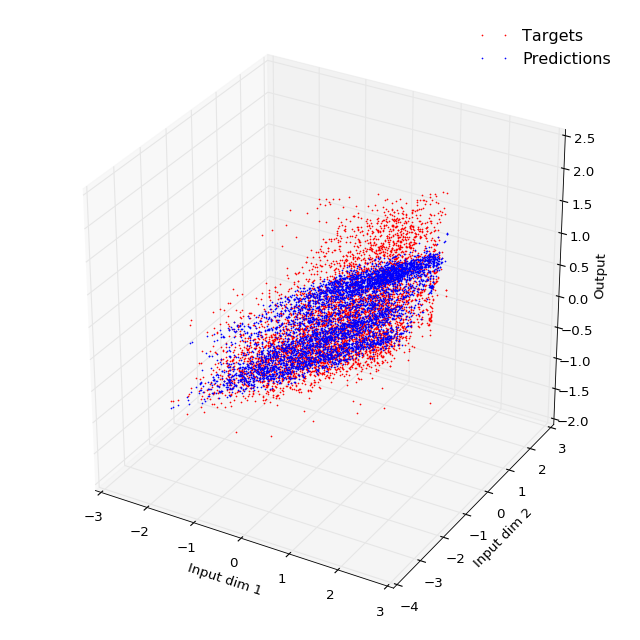

In [12]:
data_provider = CCPPDataProvider(
    which_set='train',
    input_dims=[0, 1],
    batch_size=5000, 
    max_num_batches=1, 
    shuffle_order=False
)

inputs, targets = data_provider.next()

# Calculate predicted model outputs
outputs = model.fprop(inputs)[-1]

# Plot target and predicted outputs against inputs on same axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(inputs[:, 0], inputs[:, 1], targets[:, 0], 'r.', ms=2)
ax.plot(inputs[:, 0], inputs[:, 1], outputs[:, 0], 'b.', ms=2)
ax.set_xlabel('Input dim 1')
ax.set_ylabel('Input dim 2')
ax.set_zlabel('Output')
ax.legend(['Targets', 'Predictions'], frameon=False)
fig.tight_layout()

## Optional exercise: visualising training trajectories in parameter space

Running the cell below will display an interactive widget which plots the trajectories of gradient-based training of the single-layer affine model on the CCPP dataset in the three dimensional parameter space (two weights plus bias) from random initialisations. Also shown on the right is a plot of the evolution of the cost function (evaluated on the current batch) over training. By moving the sliders you can alter the training hyperparameters to investigate the effect they have on how training procedes.

Some questions to explore:

  * Are there multiple local minima in parameter space here? Why?
  * What happens to learning for very small learning rates? And very large learning rates?
  * How does the batch size affect learning?

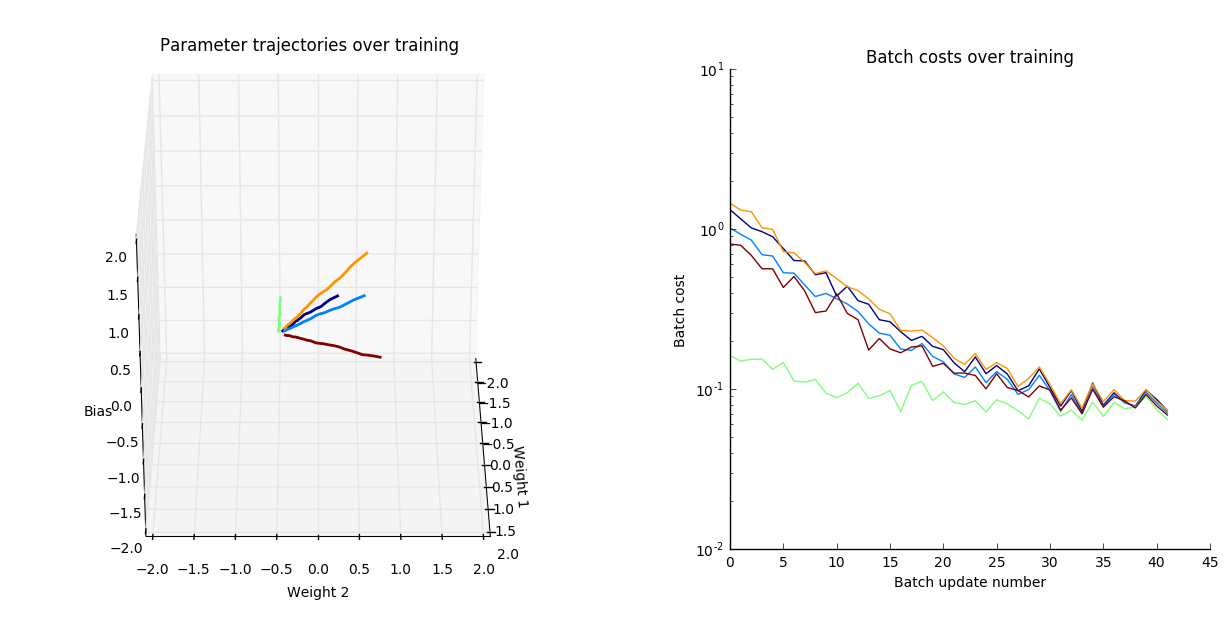

In [13]:
from ipywidgets import interact
%matplotlib inline

def setup_figure():
    # create figure and axes
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_axes([0., 0., 0.5, 1.], projection='3d')
    ax2 = fig.add_axes([0.6, 0.1, 0.4, 0.8])
    # set axes properties
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_yscale('log')
    ax1.set_xlim((-2, 2))
    ax1.set_ylim((-2, 2))
    ax1.set_zlim((-2, 2))
    #set axes labels and title
    ax1.set_title('Parameter trajectories over training')
    ax1.set_xlabel('Weight 1')
    ax1.set_ylabel('Weight 2')
    ax1.set_zlabel('Bias')
    ax2.set_title('Batch costs over training')
    ax2.set_xlabel('Batch update number')
    ax2.set_ylabel('Batch cost')
    return fig, ax1, ax2

def visualise_training(n_epochs=1, batch_size=200, log_lr=-3.5, n_inits=5,
                       w_scale=1., b_scale=1., elev=30., azim=0.):
    fig, ax1, ax2 = setup_figure()
    # create seeded random number generator
    rng = np.random.RandomState(1234)
    # create data provider
    data_provider = CCPPDataProvider(
        input_dims=[0, 1],
        batch_size=batch_size, 
        shuffle_order=False,
    )
    learning_rate = 10 ** log_lr
    n_batches = data_provider.num_batches
    weights_traj = np.empty((n_inits, n_epochs * n_batches + 1, 1, 2))
    biases_traj = np.empty((n_inits, n_epochs * n_batches + 1, 1))
    costs_traj = np.empty((n_inits, n_epochs * n_batches))
    # randomly initialise parameters
    weights = rng.uniform(-w_scale, w_scale, (n_inits, 1, 2))
    biases = rng.uniform(-b_scale, b_scale, (n_inits, 1))
    # store initial parameters
    weights_traj[:, 0] = weights
    biases_traj[:, 0] = biases
    # iterate across different initialisations
    for i in range(n_inits):
        # iterate across epochs
        for e in range(n_epochs):
            # iterate across batches
            for b, (inputs, targets) in enumerate(data_provider):
                outputs = fprop(inputs, weights[i], biases[i])
                costs_traj[i, e * n_batches + b] = cost(outputs, targets)
                grad_wrt_outputs = cost_grad(outputs, targets)
                weights_grad, biases_grad = grads_wrt_params(inputs, grad_wrt_outputs)
                weights[i] -= learning_rate * weights_grad
                biases[i] -= learning_rate * biases_grad
                weights_traj[i, e * n_batches + b + 1] = weights[i]
                biases_traj[i, e * n_batches + b + 1] = biases[i]
    # choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, n_inits))
    # plot all trajectories
    for i in range(n_inits):
        lines_1 = ax1.plot(
            weights_traj[i, :, 0, 0], 
            weights_traj[i, :, 0, 1], 
            biases_traj[i, :, 0], 
            '-', c=colors[i], lw=2)
        lines_2 = ax2.plot(
            np.arange(n_batches * n_epochs),
            costs_traj[i],
            c=colors[i]
        )
    ax1.view_init(elev, azim)
    plt.show()

w = interact(
    visualise_training,
    elev=(-90, 90, 2),
    azim=(-180, 180, 2), 
    n_epochs=(1, 5), 
    batch_size=(100, 1000, 100),
    log_lr=(-5., -2.),
    w_scale=(0., 2.),
    b_scale=(0., 2.),
    n_inits=(1, 10)
)

for child in w.widget.children:
    child.layout.width = '100%'